In [1]:
!pip install -U -q PyDrive

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!mkdir data

In [5]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [6]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [7]:
test = pd.io.sql.read_sql(
    """
    select time, diff
    from
        (
            select
                uid,
                cast((julianday(test.checker_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 as integer) as diff,
                case
                    when test.checker_ts < test.first_view_ts then 'before'
                    else 'after'
                end as time
            from test left join deadlines on test.labname = deadlines.labs
            where not test.labname = 'project1'
        )
    where uid in
        (
            select uid
            from
                (
                    select
                        uid,
                        case
                            when test.checker_ts < test.first_view_ts then 'before'
                            else 'after'
                        end as time
                    from test left join deadlines on test.labname = deadlines.labs
                    where not test.labname = 'project1'
                )
            group by uid
            having count(distinct time) = 2
        )
    """,
    conn
)

In [8]:
test['group'] = ['test'] * len(test)

In [9]:
test.head()

,time,diff,group
0,before,-148,test
1,before,-148,test
2,before,-126,test
3,before,-99,test
4,before,-98,test


In [10]:
control = pd.io.sql.read_sql(
    """
    select time, diff
    from
        (
            select
                uid,
                cast((julianday(control.checker_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 as integer) as diff,
                case
                    when control.checker_ts < control.first_view_ts then 'before'
                    else 'after'
                end as time
            from control left join deadlines on control.labname = deadlines.labs
            where not control.labname = 'project1'
        )
    where uid in
        (
            select uid
            from
                (
                    select
                        uid,
                        case
                            when control.checker_ts < control.first_view_ts then 'before'
                            else 'after'
                        end as time
                    from control left join deadlines on control.labname = deadlines.labs
                    where not control.labname = 'project1'
                )
            group by uid
            having count(distinct time) = 2
        )
    """,
    conn
)

In [11]:
control['group'] = ['control'] * len(control)

In [12]:
control.head()

,time,diff,group
0,before,-228,control
1,before,-228,control
2,before,-202,control
3,before,-202,control
4,before,-198,control


In [13]:
after = pd.concat([test.loc[test['time'] == 'after'],
                   control.loc[control['time'] == 'after']],
                  ignore_index=True)

In [14]:
after.head()

,time,diff,group
0,after,-33,test
1,after,-32,test
2,after,-28,test
3,after,-10,test
4,after,-182,test


In [15]:
before = pd.concat([test.loc[test['time'] == 'before'],
                    control.loc[control['time'] == 'before']],
                   ignore_index=True)

In [16]:
before.head()

,time,diff,group
0,before,-148,test
1,before,-148,test
2,before,-126,test
3,before,-99,test
4,before,-98,test


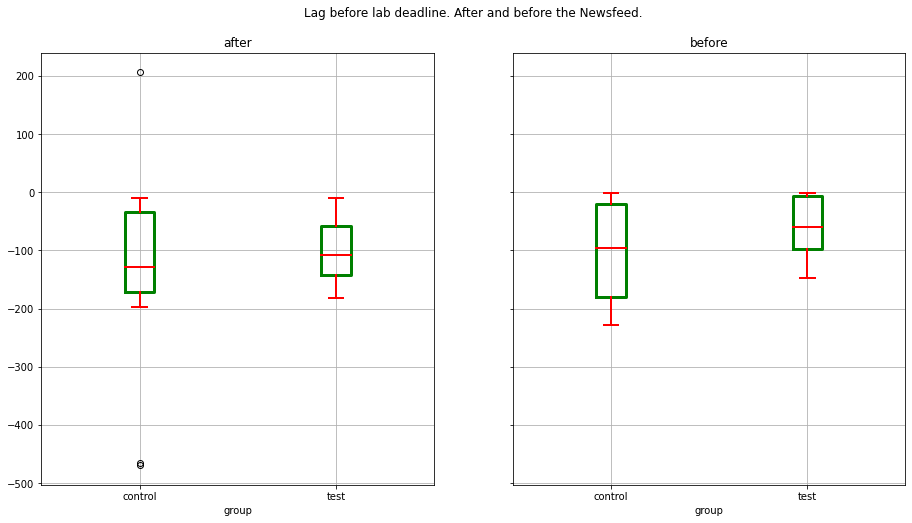

In [22]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
after.boxplot(column='diff', by='group', ax=ax[0],
              color=dict(boxes='g', whiskers='r', medians='r', caps='r'),
              boxprops=dict(linestyle='-', linewidth=3),
              medianprops=dict(linestyle='-', linewidth=2),
              whiskerprops=dict(linestyle='-', linewidth=2),
              capprops=dict(linestyle='-', linewidth=2))
before.boxplot(column='diff', by='group', ax=ax[1],
               color=dict(boxes='g', whiskers='r', medians='r', caps='r'),
               boxprops=dict(linestyle='-', linewidth=3),
               medianprops=dict(linestyle='-', linewidth=2),
               whiskerprops=dict(linestyle='-', linewidth=2),
               capprops=dict(linestyle='-', linewidth=2))
fig.suptitle('Lag before lab deadline. After and before the Newsfeed.',
             fontdict={'fontsize': 15})
ax[0].set_title('after')
ax[1].set_title('before')
plt.show()

In [ ]:
conn.close()